In [1]:
from torch import nn
import torch.cuda
import pandas as pd
import numpy as np
import tqdm
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
import utilities_diamino13_new_meta as utilities
from pathlib import Path


{'chemical_features': (0, 13), 'diamino_chemical_features': (13, 26), 'atoms': (26, 32), 'sequence_metadata': (32, 36), 'one_hot': (36, 57), 'is_modified': (57, 57)}


In [3]:
# Changing the sequence to desired form
# Pay attention to the index, +1 can be needed
def reform_seq(seq, mod):
    mod_list= [m for m in mod.split('|')]
    mod_list_tuple=[]
    if mod =='':
        return (seq)
    else:
        while mod_list:
            mod_list_tuple.append((int(mod_list.pop(0)),mod_list.pop(0)))
        mod_list_tuple.sort()
        while mod_list_tuple != []:
            tuple_mod = mod_list_tuple.pop()
            modification = tuple_mod[1]
            index = tuple_mod[0]
            seq = seq[:int(index)]+'['+modification+']'+seq[int(index):]
        return (seq)

# extract a dataset from whole data based on types
def data_separator( file, dataset, type):

    index=[]
    sequence=[]
    mod=[]
    retention=[]
    prediction=[]
    df = pd.read_csv(file ,keep_default_na=False)

    for idx, seq in enumerate(df['seq']):
        if df['data set'][idx] == dataset  and df['set_type'][idx] == type:
            index.append(idx)
            sequence.append(seq)
            mod.append(df['modifications'][idx])
            retention.append(df['tr'][idx])
            prediction.append((df['predictions'][idx]))

    data_frame=pd.DataFrame()
    data_frame['index']=index
    data_frame['seq'] = sequence
    data_frame['modifications'] = mod
    data_frame['tr'] = retention
    data_frame['predictions'] = prediction

    return data_frame

def seq_to_matrix(data, df):
    results =[]
    tr=[]
    prediction=[]
    errors=[]
    for idx,seq in tqdm.tqdm(enumerate(data)):
        try:
            result = utilities.peptide_to_matrix(seq)
            results.append(result)
            tr.append(df['tr'][idx])
            prediction.append(df['predictions'][idx])

        except KeyError as e:
            errors.append([seq,idx,e])
        except Exception as e:
            errors.append([seq,idx,e])
    results_stack = np.stack(results)
    print(len(tr),len(data),'Usable data=',len(tr) / len(data) * 100, '%')
    return results_stack, tr, prediction, errors


def dataframe_to_matrix(data, df, column_mask=None):

    results, tr, prediction, errors = utilities.df_to_matrix(data, df, column_mask)

    print(len(tr), len(data), 'Usable data=', len(tr) / len(data) * 100, '%')
    return results, tr, prediction, errors

In [4]:
standardized = True
diff_results = False

path = './Data_files/14ptm'
mods = ['Acetyl','Carbamidomethyl','Crotonyl','Deamidated','Dimethyl','Formyl','Malonyl','Methyl','Nitro','Oxidation',
       'Phospho','Propionyl','Succinyl','Trimethyl']
sets = ['train','test','valid']
columns = ['index_name','seq','modifications','tr','predictions']
for mod in mods:
    df_train = pd.read_csv(path + '/prosit_ptm_2020_' +mod+ '_modanalysis_'+sets[0]+'.csv',keep_default_na=False)
    df_test = pd.read_csv(path + '/prosit_ptm_2020_' +mod+ '_modanalysis_'+sets[1]+'.csv',keep_default_na=False)
    df_valid = pd.read_csv(path + '/prosit_ptm_2020_' +mod+ '_modanalysis_'+sets[2]+'.csv',keep_default_na=False)

    df_train = df_train[columns]
    df_test = df_test[columns]
    df_valid = df_valid[columns]


    maxx,minn=df_train['tr'].max(),df_train['tr'].min()
    for i in [ df_test, df_valid]:
        if i['tr'].min() < minn:
            minn = int(i['tr'].min())
        if i['tr'].max() > maxx:
            maxx = int(i['tr'].max())
    print('mod=',mod,'min:',minn,'max:',maxx)

    for i in [df_train, df_test, df_valid]:
        i['tr_norm'] = (i['tr'] - minn)/(maxx - minn)

    df_test_no_mod=df_test.copy()
    df_test_no_mod['modifications'].replace(f"[|][*0-9]+[|]{mod}", '',inplace=True,regex=True)
    df_test_no_mod['modifications'].replace(f"[*0-9]+[|]{mod}", '',inplace=True,regex=True)
    df_test_no_mod['modifications'].replace("^[|]|[|]$", '',inplace=True,regex=True)

    my_train = [reform_seq(df_train['seq'][i],m) for i, m in enumerate (df_train['modifications'])]
    my_test = [reform_seq(df_test['seq'][i],m) for i, m in enumerate (df_test['modifications'])]
    my_eval = [reform_seq(df_valid['seq'][i],m) for i, m in enumerate (df_valid['modifications'])]
    my_test_no_mod = [reform_seq(df_test_no_mod['seq'][i],m) for i, m in enumerate (df_test_no_mod['modifications'])]

    if standardized:
        mod = "diamino_atom_stan/"+mod
    path_save = './data_matrix/14ptm/'+mod

    if diff_results:
        temp=pd.concat([pd.DataFrame(my_test),pd.read_csv('./saved_models/14ptms/'+mod+'_results.csv')],axis=1)
        temp=temp.drop(temp.columns[[1]],axis=1)
        # temp=pd.read_csv('./saved_models/14ptms/'+mod+'_results.csv',index_col=0)
        temp['diff'] = temp['1'] - temp['0']
        temp.sort_values('diff',inplace=True)
        temp.rename(columns={0:'seq','0':'tr','1':'predict'},inplace=True)

        temp.to_csv('./saved_models/14ptms/'+mod+'_results.csv')

    if not diff_results:
        train_x, train_y, train_prediction, train_error = dataframe_to_matrix(my_train, df_train)
        test_x, test_y, test_prediction, test_error = dataframe_to_matrix(my_test, df_test)
        val_x, val_y, val_prediction, val_error = dataframe_to_matrix(my_eval, df_valid)
        test_no_mod_x, test_no_mod_y, test_no_mod_prediction, test_no_mod_error = dataframe_to_matrix(my_test_no_mod, df_test_no_mod)


        # save the matrix
        Path(path_save).mkdir(parents=True, exist_ok=True)
        np.save(path_save+'/val_prediction',val_prediction)
        np.save(path_save+'/val_x',val_x)
        np.save(path_save+'/val_y',val_y)
        np.save(path_save+'/test_x',test_x)
        np.save(path_save+'/test_y',test_y)
        np.save(path_save+'/test_prediction',test_prediction)
        np.save(path_save+'/test_no_mod_x',test_no_mod_x)
        np.save(path_save+'/test_no_mod_y',test_no_mod_y)
        np.save(path_save+'/test_no_mod_prediction',test_no_mod_prediction)
        np.save(path_save+'/train_prediction',train_prediction)
        np.save(path_save+'/train_y',train_y)
        np.save(path_save+'/train_x',train_x)


mod= Acetyl min: 7.453849999999999 max: 61.094


5182it [00:01, 4196.80it/s]


5182 5182 Usable data= 100.0 %


239it [00:00, 5069.73it/s]


239 239 Usable data= 100.0 %


272it [00:00, 8713.37it/s]


272 272 Usable data= 100.0 %


239it [00:00, 14891.76it/s]


239 239 Usable data= 100.0 %
mod= Carbamidomethyl min: 7.453849999999999 max: 61.094


4968it [00:00, 7949.32it/s]


4968 4968 Usable data= 100.0 %


464it [00:00, 5601.61it/s]


464 464 Usable data= 100.0 %


261it [00:00, 7123.28it/s]


261 261 Usable data= 100.0 %


464it [00:00, 7445.76it/s]


464 464 Usable data= 100.0 %
mod= Crotonyl min: 7.453849999999999 max: 61.094


5111it [00:00, 7446.34it/s]


5111 5111 Usable data= 100.0 %


313it [00:00, 6567.21it/s]


313 313 Usable data= 100.0 %


269it [00:00, 5691.62it/s]


269 269 Usable data= 100.0 %


313it [00:00, 28412.27it/s]


313 313 Usable data= 100.0 %
mod= Deamidated min: 7.453849999999999 max: 61.094


5199it [00:00, 7293.62it/s]


5199 5199 Usable data= 100.0 %


221it [00:00, 6985.55it/s]


221 221 Usable data= 100.0 %


273it [00:00, 8661.59it/s]


273 273 Usable data= 100.0 %


221it [00:00, 7099.03it/s]


221 221 Usable data= 100.0 %
mod= Dimethyl min: 7 max: 61


4770it [00:00, 7916.15it/s]


4770 4770 Usable data= 100.0 %


672it [00:00, 7079.87it/s]


672 672 Usable data= 100.0 %


251it [00:00, 7808.02it/s]


251 251 Usable data= 100.0 %


672it [00:00, 15053.50it/s]


672 672 Usable data= 100.0 %
mod= Formyl min: 7.453849999999999 max: 61.094


5050it [00:00, 7259.41it/s]


5050 5050 Usable data= 100.0 %


378it [00:00, 6897.87it/s]


378 378 Usable data= 100.0 %


265it [00:00, 8376.85it/s]


265 265 Usable data= 100.0 %


378it [00:00, 11948.32it/s]


378 378 Usable data= 100.0 %
mod= Malonyl min: 7.453849999999999 max: 61.094


5111it [00:00, 7162.42it/s]


5111 5111 Usable data= 100.0 %


313it [00:00, 6620.93it/s]


313 313 Usable data= 100.0 %


269it [00:00, 7052.56it/s]


269 269 Usable data= 100.0 %


313it [00:00, 12707.18it/s]


313 313 Usable data= 100.0 %
mod= Methyl min: 7.453849999999999 max: 61.094


4695it [00:00, 7577.96it/s]


4695 4695 Usable data= 100.0 %


751it [00:00, 6926.18it/s]


751 751 Usable data= 100.0 %


247it [00:00, 7807.38it/s]


247 247 Usable data= 100.0 %


751it [00:00, 11867.51it/s]


751 751 Usable data= 100.0 %
mod= Nitro min: 7.453849999999999 max: 61.094


5208it [00:00, 7647.74it/s]


5208 5208 Usable data= 100.0 %


211it [00:00, 6588.83it/s]


211 211 Usable data= 100.0 %


274it [00:00, 7470.99it/s]


274 274 Usable data= 100.0 %


211it [00:00, 13502.97it/s]


211 211 Usable data= 100.0 %
mod= Oxidation min: 7.453849999999999 max: 61.094


4276it [00:00, 8204.48it/s]


4276 4276 Usable data= 100.0 %


1192it [00:00, 5456.61it/s]


1192 1192 Usable data= 100.0 %


225it [00:00, 10166.64it/s]


225 225 Usable data= 100.0 %


1192it [00:00, 9362.41it/s]

1192 1192 Usable data= 100.0 %


mod= Phospho min: 7.453849999999999 max: 61


5209it [00:00, 7224.85it/s]


5209 5209 Usable data= 100.0 %


210it [00:00, 6744.54it/s]


210 210 Usable data= 100.0 %


274it [00:00, 8801.58it/s]


274 274 Usable data= 100.0 %


210it [00:00, 9488.76it/s]


210 210 Usable data= 100.0 %
mod= Propionyl min: 7.453849999999999 max: 61.094


5084it [00:00, 7144.10it/s]


5084 5084 Usable data= 100.0 %


342it [00:00, 6435.12it/s]


342 342 Usable data= 100.0 %


267it [00:00, 7188.11it/s]


267 267 Usable data= 100.0 %


342it [00:00, 21360.95it/s]


342 342 Usable data= 100.0 %
mod= Succinyl min: 7.453849999999999 max: 61.094


5090it [00:00, 6935.09it/s]


5090 5090 Usable data= 100.0 %


336it [00:00, 6037.14it/s]


336 336 Usable data= 100.0 %


267it [00:00, 5649.54it/s]


267 267 Usable data= 100.0 %


336it [00:00, 13990.59it/s]


336 336 Usable data= 100.0 %
mod= Trimethyl min: 7.453849999999999 max: 61.094


5082it [00:00, 6863.70it/s]


5082 5082 Usable data= 100.0 %


344it [00:00, 6071.92it/s]


344 344 Usable data= 100.0 %


267it [00:00, 8439.88it/s]


267 267 Usable data= 100.0 %


344it [00:00, 22014.66it/s]

344 344 Usable data= 100.0 %


# Separate R Dimethyl

In [7]:
df_test = pd.read_csv('./Data_files/14ptm' + '/prosit_ptm_2020_' +'Dimethyl'+ '_modanalysis_'+'test'+'.csv',keep_default_na=False)
columns = ['index_name','seq','modifications','tr','predictions']

In [9]:
df_test = df_test[columns]
my_test = [reform_seq(df_test['seq'][i],m) for i, m in enumerate (df_test['modifications'])]
my_test

['GGNFGGR[Dimethyl]GGYGGGGGGSR',
 'GAR[Dimethyl]LPGPVSSAR',
 'ANYNFRGM[Oxidation]YNQR[Dimethyl]',
 'LLALSGPGGGR[Dimethyl]GR',
 'FGDM[Oxidation]SYSIR[Dimethyl]HSISM[Oxidation]PAM[Oxidation]R',
 'PGTPAGYGRGR[Dimethyl]',
 'GPPR[Dimethyl]GGPGGELPR',
 'MTEDALR[Dimethyl]LNLLK',
 'AR[Dimethyl]GWAGVER',
 'AR[Dimethyl]GGC[Carbamidomethyl]PGGEATLSQPPPR',
 'VEPGSLESSPGLGR[Dimethyl]GR',
 'STNVTVAAAR[Dimethyl]GIK',
 'VTR[Dimethyl]YPILGIPQAHR',
 'FGR[Dimethyl]GTGLTQPSQR',
 'GGGDR[Dimethyl]GGFGPGK',
 'GLATFPSR[Dimethyl]GAK',
 'R[Dimethyl]GATPPAPPR',
 'VLATQPGPGRGR[Dimethyl]',
 'GSYLGGYSAGRGIYSR[Dimethyl]',
 'SGSNWGR[Dimethyl]GSNM[Oxidation]NSGPPR',
 'FSHSVQNSER[Dimethyl]GK',
 'R[Dimethyl]GTVGAGC[Carbamidomethyl]GFNQR',
 'GR[Dimethyl]GLPGPAESLR',
 'GR[Dimethyl]GAPPPPPSR',
 'LGTTPSVYGGAGGR[Dimethyl]GIR',
 'PLPVALQTR[Dimethyl]LAK',
 'FGDSR[Dimethyl]GGGGNFGPGPGSNFR',
 'SGGGGYSQNR[Dimethyl]WGNNNR',
 'GGNFGGRGGYGGGGGGSR[Dimethyl]',
 'VTVAR[Dimethyl]GSALEM[Oxidation]EFK',
 'YGR[Dimethyl]GQLNYPLPDFSK',
 'FGP

In [6]:
temp=pd.concat([pd.DataFrame(my_test),pd.read_csv('./saved_models/14ptms/'+mod+'_results.csv')],axis=1)

temp

,0,Unnamed: 0,0,1
0,ITESVAETAQTIK[Acetyl]K,0,31.570625,31.919634
1,ILDLK[Acetyl]TGTVK,1,36.621750,36.864071
2,GAEK[Acetyl]TEVAEPR,2,20.129126,20.192793
3,IHNAENIQPGEQK[Acetyl]YEYK,3,25.592251,26.082335
4,DTM[Oxidation]GIADK[Acetyl]TENTLER,4,33.042500,33.772171
...,...,...,...,...
234,VGTASVLQPVK[Acetyl]K,234,31.625500,32.233959
235,MSFVK[Acetyl]GWGAEYR,235,42.429501,41.366127
236,SSGPGGQNVNK[Acetyl]VNSK,236,16.240625,16.090347
237,SPSDSGYSYETIGK[Acetyl]TTK,237,30.199375,30.594339


In [8]:
np.load('./data_matrix/14ptm/diamino13_stan/Acetyl/test_x.npy')[6]==np.load('./data_matrix/14ptm/diamino13_p1_stan/Acetyl/test_x.npy')[6]

array([[ True, False, False, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [9]:
np.load('./data_matrix/14ptm/diamino13_stan/Trimethyl/train_x.npy')[0]

array([[ 0.    , -0.9487, -0.9487, ...,  0.    ,  0.    ,  0.    ],
       [ 0.    , -1.967 , -1.967 , ...,  0.    ,  0.    ,  0.    ],
       [ 0.    , -1.997 , -1.997 , ...,  0.    ,  0.    ,  0.    ],
       ...,
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ]],
      dtype=float16)

In [11]:
np.load('./data_matrix/14ptm/diamino13_p1_stan/Trimethyl/train_x.npy')[0]

array([[ 0.    , -0.9497, -0.9497, ...,  0.    ,  0.    ,  0.    ],
       [ 0.    , -1.967 , -1.967 , ...,  0.    ,  0.    ,  0.    ],
       [ 0.    , -1.997 , -1.997 , ...,  0.    ,  0.    ,  0.    ],
       ...,
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ]],
      dtype=float16)

In [10]:
df=pd.read_csv('./struct_to_features_20230704.csv')
df[df.columns[1]]=0
df=df.set_index('name').T
df

name,Propionyl#K,Oxidation#M,Carbamidomethyl#C,Methyl#C,Methyl#E,Methyl#N,Methyl#K,Dimethyl#N,Dimethyl#K,Dimethyl#R,...,Formyl#K,Deamidated#R,Deamidated#F,Deamidated#N,Deamidated#Q,Malonyl#K,Nitro#Y,Biotin#K,Oxidation#P,Methyl#R
BalabanJ_rdkit,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Chi0n_rdkit,8.453945,5.740873,5.818223,4.625517,6.240873,5.625517,6.838590,6.572731,7.785803,8.578696,...,6.824188,6.578696,6.473884,4.572731,5.279838,8.809407,8.160244,14.330919,4.871590,7.631483
LabuteASA_rdkit,83.665819,61.868920,68.119189,52.252834,64.134675,58.206050,66.774412,64.780964,73.349326,83.584539,...,70.935935,69.889055,70.276219,51.085480,57.450422,92.621575,90.269085,151.593108,52.493040,77.009626
MinPartialCharge_rdkit,-0.480086,-0.480086,-0.480064,-0.480064,-0.480086,-0.480075,-0.480086,-0.480075,-0.480086,-0.480086,...,-0.480086,-0.481013,-0.479319,-0.481175,-0.481229,-0.480854,-0.502092,-0.480086,-0.480080,-0.480086
MolLogP_rdkit,0.094800,-0.833100,-1.383200,-0.238700,-0.648500,-1.465600,-0.212000,-1.123400,0.130200,-1.026700,...,-0.685400,-0.739130,0.674600,-1.127000,-0.736900,-0.840500,0.254800,0.410600,-1.206200,-1.077730
TPSA_rdkit,92.420000,80.390000,106.410000,63.320000,89.620000,92.420000,75.350000,83.630000,66.560000,99.740000,...,92.420000,119.430000,57.530000,100.620000,100.620000,129.720000,126.690000,133.550000,69.560000,111.230000
SlogP_VSA1_rdkit,11.050456,5.733667,11.467335,5.733667,5.733667,11.050456,11.050456,5.733667,5.733667,16.367245,...,11.050456,11.050456,0.000000,5.733667,5.733667,11.050456,5.733667,21.684033,5.316789,16.367245
SlogP_VSA2_rdkit,29.569610,33.335195,34.530560,29.126296,30.196776,30.072525,30.710102,42.020107,42.657684,43.717328,...,30.072525,34.790637,22.286326,28.193506,28.193506,40.645442,27.147512,58.687197,34.872924,36.669656
SMR_VSA1_rdkit,14.695602,14.109963,14.695602,9.901065,19.432465,14.695602,9.901065,14.695602,9.901065,9.901065,...,14.695602,15.007592,15.007592,19.802129,19.802129,24.596666,19.930903,19.490139,15.007592,9.901065
SMR_VSA2_rdkit,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,5.409284,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.409284


In [4]:
standardized = True


path = './Data_files/14ptm'
mods = ['Nitro']
sets = ['train','test','valid']
columns = ['index_name','seq','modifications','tr','predictions']
for mod in mods:
    df_train = pd.read_csv(path + '/prosit_ptm_2020_' +mod+ '_modanalysis_'+sets[0]+'.csv',keep_default_na=False)
    df_test = pd.read_csv(path + '/prosit_ptm_2020_' +mod+ '_modanalysis_'+sets[1]+'.csv',keep_default_na=False)
    df_valid = pd.read_csv(path + '/prosit_ptm_2020_' +mod+ '_modanalysis_'+sets[2]+'.csv',keep_default_na=False)

    df_train = df_train[columns]
    df_test = df_test[columns]
    df_valid = df_valid[columns]


    maxx,minn=df_train['tr'].max(),df_train['tr'].min()
    for i in [ df_test, df_valid]:
        if i['tr'].min() < minn:
            minn = int(i['tr'].min())
        if i['tr'].max() > maxx:
            maxx = int(i['tr'].max())
    print('mod=',mod,'min:',minn,'max:',maxx)

    for i in [df_train, df_test, df_valid]:
        i['tr_norm'] = (i['tr'] - minn)/(maxx - minn)

    df_test_no_mod=df_test.copy()
    df_test_no_mod['modifications'].replace(f"[|][*0-9]+[|]{mod}", '',inplace=True,regex=True)
    df_test_no_mod['modifications'].replace(f"[*0-9]+[|]{mod}", '',inplace=True,regex=True)
    df_test_no_mod['modifications'].replace("^[|]|[|]$", '',inplace=True,regex=True)

    my_train = [reform_seq(df_train['seq'][i],m) for i, m in enumerate (df_train['modifications'])]
    my_test = [reform_seq(df_test['seq'][i],m) for i, m in enumerate (df_test['modifications'])]
    my_eval = [reform_seq(df_valid['seq'][i],m) for i, m in enumerate (df_valid['modifications'])]
    my_test_no_mod = [reform_seq(df_test_no_mod['seq'][i],m) for i, m in enumerate (df_test_no_mod['modifications'])]


    train_x, train_y, train_prediction, train_error = dataframe_to_matrix(my_train, df_train)
    test_x, test_y, test_prediction, test_error = dataframe_to_matrix(my_test, df_test)
    val_x, val_y, val_prediction, val_error = dataframe_to_matrix(my_eval, df_valid)
    test_no_mod_x, test_no_mod_y, test_no_mod_prediction, test_no_mod_error = dataframe_to_matrix(my_test_no_mod, df_test_no_mod)



mod= Nitro min: 7.453849999999999 max: 61.094


5208it [00:00, 8408.19it/s]


5208 5208 Usable data= 100.0 %


211it [00:00, 13103.71it/s]


211 211 Usable data= 100.0 %


274it [00:00, 8968.76it/s]


274 274 Usable data= 100.0 %


211it [00:00, 13502.76it/s]

211 211 Usable data= 100.0 %


In [12]:
my_test_no_mod

['LGDVYVNDAFGTAHR',
 'TEVNSGFFYK',
 'TAIQAAGYPDK',
 'GSELQNYFTK',
 'LAEQEAHYAVR',
 'YVHADAPTNK',
 'YHEDIFGLTLR',
 'LDLSSLAYSGK',
 'SYVDTGGVSR',
 'AYILNLVK',
 'IFDSEEILAGYK',
 'AYGELPEHAK',
 'YLHDESGLNR',
 'ALYETELADAR',
 'DYIM[Oxidation]EPSIFNTLK',
 'LQEVEAEVAATGTYQLR',
 'FLQEFYQDDELGK',
 'LSSETYSQAK',
 'YLEC[Carbamidomethyl]ISC[Carbamidomethyl]GSSDM[Oxidation]SC[Carbamidomethyl]ER',
 'YQAEFPM[Oxidation]GPVTSAHAGTYR',
 'PATSYVR',
 'LEENHYNTYISK',
 'TPENYPNAGLTM[Oxidation]NYC[Carbamidomethyl]R',
 'GVEAVGSYAENQR',
 'YNILEDVAVC[Carbamidomethyl]M[Oxidation]DLDTR',
 'TYVQDILR',
 'AQLSQYFDAVK',
 'GHYTIGK',
 'DLIDTYLLHM[Oxidation]EK',
 'C[Carbamidomethyl]YYGSDTAGR',
 'LELAQYR',
 'YSTSGSSGLTTGK',
 'DYSVTANSK',
 'LAPEYEAAATR',
 'VFLDC[Carbamidomethyl]C[Carbamidomethyl]NYITELR',
 'GYLGPEQLPDC[Carbamidomethyl]LK',
 'VHATSTYR',
 'GVQYLNEIK',
 'SYSVGASGSSSR',
 'DM[Oxidation]AQSIYR',
 'DLTTAGAVTQC[Carbamidomethyl]YR',
 'YADLTEDQLPSC[Carbamidomethyl]ESLK',
 'M[Oxidation]AGLELLSDQGYR',
 'SAQEM[Oxidati

In [4]:
np.load('./data_matrix/14ptm/diamino13/Acetyl/train_x.npy')

array([[[ 0.    , -0.534 , -0.534 , ...,  0.    ,  0.    ,  0.    ],
        [ 0.    , -1.938 , -1.938 , ...,  0.    ,  0.    ,  0.    ],
        [ 0.    , -1.903 , -1.903 , ...,  0.    ,  0.    ,  0.    ],
        ...,
        [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ]],

       [[ 0.    , -1.064 ,  1.062 , ...,  0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.0905, -0.6855, ...,  0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.2418, -0.914 , ...,  0.    ,  0.    ,  0.    ],
        ...,
        [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ]],

       [[ 0.    , -0.534 ,  1.051 , ...,  0.    ,  0.    ,  0.    ],
        [ 0.    , -1.938 , -0.949 , ...,  0.    ,  0.    ,  0.    ],
    

In [ ]:
print('Shape of train set: ',train_x.shape)
print('Shape of test set: ', test_x.shape)
print('Shape of val set: ', val_x.shape)
print('Shape of test no mod set: ', test_no_mod_x.shape)

In [7]:
pd.DataFrame(train_x[0])

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,0.000000,-0.534180,-0.534180,-1.538086,-0.534180,0.294434,-1.538086,-0.534180,0.294434,-1.538086,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,0.000000,-1.938477,-1.938477,-0.958496,-1.938477,-1.493164,-0.958496,-1.938477,-1.493164,-0.958496,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,0.000000,-1.903320,-1.903320,-0.955566,-1.903320,-1.573242,-0.955566,-1.903320,-1.573242,-0.955566,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,0.000000,-0.739258,-0.739258,-0.734863,-0.739258,-0.734863,-0.734863,-0.739258,-0.734863,-0.734863,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,0.000000,-0.196533,-0.196533,0.676758,-0.196533,0.231079,0.676758,-0.196533,0.231079,0.676758,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
5,0.000000,-0.862793,-0.862793,-1.410156,-0.862793,-0.862793,-1.410156,-0.862793,-0.862793,-1.410156,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
6,0.000000,-0.569824,-0.569824,-0.657227,-0.569824,-0.569824,-0.657227,-0.569824,-0.569824,-0.657227,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
7,0.000000,-1.576172,-1.576172,-0.951172,-1.576172,-1.627930,-0.951172,-1.576172,-1.627930,-0.951172,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
8,0.000000,-0.629395,-0.629395,-0.629395,-0.629395,-0.629395,-0.629395,-0.629395,-0.629395,-0.629395,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
9,0.000000,-0.134888,-0.134888,-0.134888,-0.134888,-0.134888,-0.134888,-0.134888,-0.134888,-0.134888,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [8]:
# Initialize the hyper parameters

def get_config(lr= 1e-3, epoch= 300, batch= 64):
    config={
        "learning_rate" : lr,
        "epochs" : epoch,
        "batch_size" : batch
    }

    return config

In [9]:

# Making the pytorch dataset

class MyDataset(Dataset):
    def __init__(self, sequences, retention):
        self.sequences = sequences
        self.retention = retention

    def __len__(self):
        return len(self.retention)

    def __getitem__(self, idx):
        return (self.sequences[idx], self.retention[idx])

In [10]:
# Initiate Dataloaders

train_dataset = MyDataset(train_x, train_y)
val_dataset = MyDataset(val_x, val_y)
test_dataset = MyDataset(test_x, test_y)
test_no_mod_dataset = MyDataset(test_no_mod_x, test_no_mod_y)

config = get_config()

dataloader_train = DataLoader(train_dataset, shuffle=True, batch_size=config["batch_size"])
dataloader_val = DataLoader(val_dataset, pin_memory=True)
dataloader_test = DataLoader(test_dataset, pin_memory=True)
dataloader_test_no_mod = DataLoader(test_no_mod_dataset, pin_memory=True)

In [11]:
# Create Network architecture

class MyNet(nn.Module):
    def __init__(self):
        super(MyNet,self).__init__()
        self.l = nn.ModuleList()

        self.l.append(nn.Conv1d(in_channels=30, out_channels=100, kernel_size=(3,), stride=(1,), padding=(1,)))
        self.l.append(nn.ReLU())
        self.l.append(nn.Dropout(p=0.2, inplace=False))

        self.l.append(nn.Conv1d(in_channels=100, out_channels=100, kernel_size=(3,), stride=(1,), padding=(1,)))
        self.l.append(nn.ReLU())
        self.l.append(nn.Dropout(p=0.2, inplace=False))

        self.l.append(nn.Conv1d(in_channels=100, out_channels=64, kernel_size=(4,), stride=(1,), padding=(1,)))
        self.l.append(nn.ReLU())
        self.l.append(nn.Dropout(p=0.2, inplace=False))

        self.l.append(nn.Flatten())

        self.l.append(nn.Linear(in_features=64*51, out_features=1024))
        self.l.append(nn.ReLU())
        
        self.l.append(nn.Linear(in_features=1024, out_features=512))
        self.l.append(nn.ReLU())
        self.l.append(nn.Linear(in_features=512, out_features=128))
        self.l.append(nn.ReLU())

        self.l.append(nn.Linear(in_features=128, out_features=1))
        self.l.append(nn.Linear(1,1))

    def forward(self, x):
        for layer in self.l:
            x = layer(x)

        return x

In [12]:
# First look at Network

print(MyNet().parameters)
print("Total Parameters =  ",sum(p.numel() for p in MyNet().parameters()))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MyNet()
model.to(device)

for batch in dataloader_train:
    X, y = batch[0].to(device), batch[1].to(device)
    X = X.float()
    print(X.dtype)
    print('X is cuda:',X.is_cuda)
    print('X.shape:',X.shape)
    print('y.shape:',y.shape)
    outputs = model(X)
    print('outputs.shape:',outputs.shape)
    break


<bound method Module.parameters of MyNet(
  (l): ModuleList(
    (0): Conv1d(30, 100, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Conv1d(100, 100, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Conv1d(100, 64, kernel_size=(4,), stride=(1,), padding=(1,))
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=3264, out_features=1024, bias=True)
    (11): ReLU()
    (12): Linear(in_features=1024, out_features=512, bias=True)
    (13): ReLU()
    (14): Linear(in_features=512, out_features=128, bias=True)
    (15): ReLU()
    (16): Linear(in_features=128, out_features=1, bias=True)
    (17): Linear(in_features=1, out_features=1, bias=True)
  )
)>
Total Parameters =   3998819
torch.float32
X is cuda: True
X.shape: torch.Size([64, 30, 52])
y.shape: torch.Size([64])
outputs.shape: torch.Size([64, 1

In [35]:
from torchsummary import summary
summary(model,input_size=( 30,52))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 100, 52]           9,100
              ReLU-2              [-1, 100, 52]               0
           Dropout-3              [-1, 100, 52]               0
            Conv1d-4              [-1, 100, 52]          30,100
              ReLU-5              [-1, 100, 52]               0
           Dropout-6              [-1, 100, 52]               0
            Conv1d-7               [-1, 64, 51]          25,664
              ReLU-8               [-1, 64, 51]               0
           Dropout-9               [-1, 64, 51]               0
          Flatten-10                 [-1, 3264]               0
           Linear-11                 [-1, 1024]       3,343,360
             ReLU-12                 [-1, 1024]               0
           Linear-13                  [-1, 512]         524,800
             ReLU-14                  [

In [22]:
from torchviz import make_dot
model = MyNet()
model.to(device)
X, y = batch[0].to(device), batch[1].to(device)
X = X.float()
y = model(X)   
MyConvNetVis = make_dot(y)
MyConvNetVis.format = "png"
MyConvNetVis.directory = "graph"
MyConvNetVis.view()
    


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [19]:
#import random

def train(model, loader, loss):
    current_loss=0
    model.train()

    # reading the data
    for idx,batch in enumerate(loader):
        X,y = batch
        # move data to gpu if possible
        if device.type == 'cuda':
            X,y = X.to(device), y.to(device)
        # training steps
        optimizer.zero_grad()
        X = X.float()
        y = y.float()
        output = model(X)
        loss_fn=loss(output,y.reshape(-1,1))
        loss_fn.backward()
        optimizer.step()

        current_loss += loss_fn.item()*X.size(0)
        correlation = np.corrcoef(output.cpu().detach().numpy().flat,y.cpu()).min()

        if idx % 100 == 0:    # print every 2000 mini-batches
            print('epoch: %d, train_loss: %.3f' %(epoch + 1, loss_fn.item()), "Training correlation:", correlation)

            # showing some examples of prediction
            # print("5 Random samples: ")
            # for i in random.sample(range(0,len(output)),5):
            #    print('predict: %.3f, real: %.3f'%(output[i].item(),y[i].item()))
            # print('')

    epoch_loss = current_loss / len(loader.dataset)
    return epoch_loss

In [20]:
def validation(model, loader, loss):
    current_loss=0
    model.eval()
    outputs=[]
    ys = []
    # reading the data
    for idx,batch in enumerate(loader):
        X,y = batch
        # move data to gpu if possible
        if device.type == 'cuda':
            X,y = X.to(device), y.to(device)
        # validating steps

        X = X.float()
        y = y.float()
        output = model(X)
        ys.append(y.item())
        outputs.append(output.item())
        loss_fn=loss(output,y.reshape(-1,1))

        current_loss += loss_fn.item()*X.size(0)
        #print('loss: %.3f' %(loss_fn.item()))
    #print('number of outputs: ',len(output))

    correlation = np.corrcoef(outputs,ys).min()
    epoch_loss = current_loss / len(loader.dataset)
    return epoch_loss,correlation, outputs, ys

In [21]:
# Running the training

import wandb

wandb.init(config= config, project="14ptms", entity="alirezak2",)

model = MyNet()
model.to(device)

# Hyper parameters

epochs =wandb.config["epochs"]
learning_rate = wandb.config["learning_rate"]
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), learning_rate)


wandb.watch(model)

# Training the model

for epoch in range(epochs):
    loss_train = train(model, dataloader_train, loss_function )
    loss_valid, corr, output, y = validation(model, dataloader_val, loss_function )

    print('\n Epoch: {}  Train Loss: {:.4f}  Validation Loss: {:.4f}  Validation Correlation: {:.4f}\n'
          .format(epoch + 1, loss_train, loss_valid, corr))


    wandb.log({
        "Epoch": epoch,
        "Train Loss Averaged": loss_train,
        "Correlation": corr,
        "Valid Loss Averaged": loss_valid,
        #"Valid Acc": acc_valid
        })




wandb: Currently logged in as: alirezak2 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


epoch: 1, train_loss: 949.113 Training correlation: 0.07334440106207112

 Epoch: 1  Train Loss: 223.0986  Validation Loss: 88.4937  Validation Correlation: 0.6196

epoch: 2, train_loss: 95.728 Training correlation: 0.5206937549563372

 Epoch: 2  Train Loss: 79.2248  Validation Loss: 62.1701  Validation Correlation: 0.7950

epoch: 3, train_loss: 57.451 Training correlation: 0.7729285472555345

 Epoch: 3  Train Loss: 50.8168  Validation Loss: 34.7557  Validation Correlation: 0.8615

epoch: 4, train_loss: 41.161 Training correlation: 0.867093949859554

 Epoch: 4  Train Loss: 41.3189  Validation Loss: 30.1162  Validation Correlation: 0.8846

epoch: 5, train_loss: 36.613 Training correlation: 0.8653718195139077

 Epoch: 5  Train Loss: 34.1702  Validation Loss: 26.8575  Validation Correlation: 0.8992

epoch: 6, train_loss: 27.970 Training correlation: 0.8884483372796186

 Epoch: 6  Train Loss: 33.3212  Validation Loss: 24.6957  Validation Correlation: 0.9016

epoch: 7, train_loss: 27.271 Tra

In [22]:
loss_function = nn.MSELoss()
loss_test, corr_test, output_test, y_test = validation(model, dataloader_test, loss_function)
print('\n Test set Loss: {:.4f}  Test set Correlation: {:.4f}\n'
      .format(loss_test, corr_test))
output = output_test
y = y_test


 Test set Loss: 2.4689  Test set Correlation: 0.9934



In [23]:
loss_test_no_mod, corr_tes_no_mod, output_test_no_mod, y_test_no_mod = validation(model, dataloader_test_no_mod, loss_function)
print('\n Test set no mod Loss: {:.4f}  Test set no mod Correlation: {:.4f}\n'
      .format(loss_test_no_mod, corr_tes_no_mod))
output = output_test_no_mod
y = y_test_no_mod


 Test set no mod Loss: 49.9177  Test set no mod Correlation: 0.9535



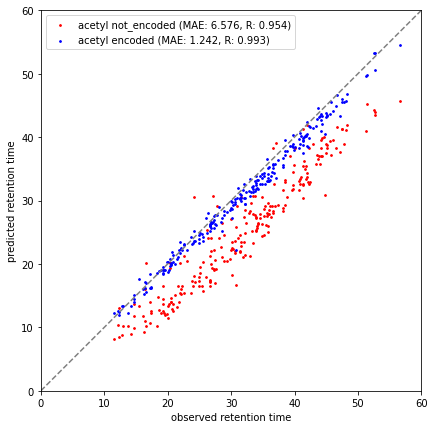

In [25]:
mod = "acetyl"
fig = plt.figure(figsize=(7, 7))
ax1 = fig.add_subplot(111)
mae_test = mean_absolute_error(output_test,y_test)
mae_no_mod = mean_absolute_error(output_test_no_mod,y_test_no_mod)

ax1.scatter(y_test_no_mod,output_test_no_mod,c='r',label=mod+
            ' not_encoded (MAE: {:.3f}, R: {:.3f})'.format(mae_no_mod, corr_tes_no_mod),s=3)
ax1.scatter(y_test,output_test,c='b',label=mod+
            ' encoded (MAE: {:.3f}, R: {:.3f})'.format(mae_test, corr_test),s=3)

plt.legend(loc='upper left')
plt.xlabel('observed retention time')
plt.ylabel('predicted retention time')
plt.axis('scaled')
ax1.plot([0, 60], [0, 60], ls="--", c=".5")
plt.xlim(0,60)
plt.ylim(0,60)
plt.show()

default data, without normalization
Pearson Correlation: 
 [[1.         0.95166141]
 [0.95166141 1.        ]]
RSE= 0.4425666399462667
R-Square= 0.9056594349815884
rmse= 0.44071100644878364
mae= 6.3081758251748825


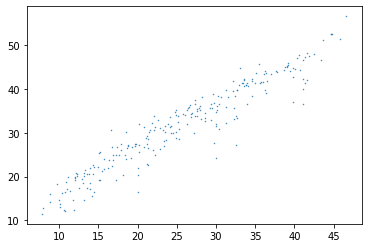

In [79]:
# Metrics
output_arrayed= np.array(output).reshape(-1,1)
y_arrayed= np.array(y).reshape(-1,1)
linear_regressor = LinearRegression()
linear_regressor.fit(output_arrayed,y_arrayed)

num_data = len(y)

pear = np.corrcoef(output,y)
mse = mean_squared_error(output,y)
rmse = math.sqrt(mse/num_data)
rse = math.sqrt(mse/(num_data-2))
rsquare=linear_regressor.score(output_arrayed,y_arrayed)
mae=mean_absolute_error(output,y)

print('default data, without normalization')
print('Pearson Correlation: \n', pear)
print('RSE=',rse)
print('R-Square=',rsquare)
print('rmse=',rmse)
print('mae=',mae)
plt.scatter(output,y,s=0.2,)


In [96]:
# Saving the model
path = './saved_models/14ptms/300_acetyl2.pth'
torch.save(model.state_dict(), path)

In [14]:
# Loading the model
path = './saved_models/14ptms/300_acetyl2.pth'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [80]:
config = get_config()
type(config["loss_function"]())

torch.nn.modules.loss.MSELoss

Correlation,▁▅▆▆▆▆▇▇▆▆▇▇▇▇█▇▇▇▇█████████████████████
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
No mod Test set Correlation,▁██▆▇▆▇▇▆▆▆▇▇▇▇▇▇▇▆▇▆▇▇▇▆▆▆▆▆▆▇▇▇▆▆▇▇▇▆▇
Test set Correlation,▁▇▇▇▇▇█▇▇▆▇███████▇█████████████████████
Total Parameters,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Loss Averaged,█▅▄▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Valid Loss Averaged,█▆▃▄▄▄▃▃▂▃▂▂▂▂▂▁▂▂▁▂▁▁▂▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁
Correlation,0.97158
Epoch,400
No mod Test set Correlation,0.95129
Test set Correlation,0.98887


wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


<bound method Module.parameters of MyNet(
  (l): ModuleList(
    (0): Conv1d(30, 100, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): Conv1d(100, 100, kernel_size=(5,), stride=(1,), padding=(2,))
    (3): ReLU()
    (4): Dropout(p=0.15, inplace=False)
    (5): Conv1d(100, 100, kernel_size=(5,), stride=(1,), padding=(2,))
    (6): ReLU()
    (7): Dropout(p=0.15, inplace=False)
    (8): MaxPool1d(kernel_size=(5,), stride=(1,), padding=(2,), dilation=1, ceil_mode=False)
    (9): Conv1d(100, 100, kernel_size=(5,), stride=(1,), padding=(2,))
    (10): ReLU()
    (11): Dropout(p=0.15, inplace=False)
    (12): Conv1d(100, 100, kernel_size=(5,), stride=(1,), padding=(2,))
    (13): ReLU()
    (14): Dropout(p=0.15, inplace=False)
    (15): MaxPool1d(kernel_size=(5,), stride=(1,), padding=(2,), dilation=1, ceil_mode=False)
    (16): Conv1d(100, 100, kernel_size=(5,), stride=(1,), padding=(2,))
    (17): ReLU()
    (18): Dropout(p=0.15, inplace=False)
    (19): Conv1d(100, 1


 Epoch: 35  Train Loss: 9.5109  Validation Loss: 229.9494  Validation Correlation: 0.9526

epoch: 36, train_loss: 14.767 Training correlation: 0.9617120156511486

 Epoch: 36  Train Loss: 9.0792  Validation Loss: 196.1069  Validation Correlation: 0.9510

epoch: 37, train_loss: 8.648 Training correlation: 0.9676953724010984

 Epoch: 37  Train Loss: 8.2891  Validation Loss: 226.4238  Validation Correlation: 0.9562

epoch: 38, train_loss: 19.872 Training correlation: 0.934532203790244

 Epoch: 38  Train Loss: 7.9383  Validation Loss: 253.8570  Validation Correlation: 0.9573

epoch: 39, train_loss: 17.009 Training correlation: 0.9817043585902671

 Epoch: 39  Train Loss: 9.5253  Validation Loss: 191.5226  Validation Correlation: 0.9542

epoch: 40, train_loss: 5.354 Training correlation: 0.979302117598117

 Epoch: 40  Train Loss: 7.2303  Validation Loss: 200.6464  Validation Correlation: 0.9550

epoch: 41, train_loss: 6.879 Training correlation: 0.972537999018373

 Epoch: 41  Train Loss: 7.0


 Epoch: 86  Train Loss: 4.6564  Validation Loss: 99.2613  Validation Correlation: 0.9658

epoch: 87, train_loss: 14.628 Training correlation: 0.99057106042267

 Epoch: 87  Train Loss: 5.1494  Validation Loss: 138.2736  Validation Correlation: 0.9614

epoch: 88, train_loss: 4.699 Training correlation: 0.983903436004073

 Epoch: 88  Train Loss: 4.7768  Validation Loss: 124.1355  Validation Correlation: 0.9664

epoch: 89, train_loss: 3.568 Training correlation: 0.984974075784924

 Epoch: 89  Train Loss: 4.5622  Validation Loss: 95.2543  Validation Correlation: 0.9635

epoch: 90, train_loss: 6.722 Training correlation: 0.992289275887873

 Epoch: 90  Train Loss: 3.4100  Validation Loss: 104.0640  Validation Correlation: 0.9654

epoch: 91, train_loss: 6.594 Training correlation: 0.9899498585965285

 Epoch: 91  Train Loss: 3.8763  Validation Loss: 109.4785  Validation Correlation: 0.9637

epoch: 92, train_loss: 6.953 Training correlation: 0.9893509916152531

 Epoch: 92  Train Loss: 3.7310  V


 Epoch: 137  Train Loss: 2.7013  Validation Loss: 81.9489  Validation Correlation: 0.9717

epoch: 138, train_loss: 3.241 Training correlation: 0.9962489064677895

 Epoch: 138  Train Loss: 2.8621  Validation Loss: 75.6588  Validation Correlation: 0.9718

epoch: 139, train_loss: 5.574 Training correlation: 0.9921981158577179

 Epoch: 139  Train Loss: 2.2877  Validation Loss: 90.6491  Validation Correlation: 0.9726

epoch: 140, train_loss: 1.566 Training correlation: 0.9957469542007278

 Epoch: 140  Train Loss: 1.8493  Validation Loss: 95.3125  Validation Correlation: 0.9700

epoch: 141, train_loss: 1.656 Training correlation: 0.9939380398271448

 Epoch: 141  Train Loss: 2.1959  Validation Loss: 84.5687  Validation Correlation: 0.9703

epoch: 142, train_loss: 3.223 Training correlation: 0.9925733888227584

 Epoch: 142  Train Loss: 2.6206  Validation Loss: 89.9503  Validation Correlation: 0.9746

epoch: 143, train_loss: 2.436 Training correlation: 0.994752048948668

 Epoch: 143  Train Los


 Epoch: 188  Train Loss: 1.6759  Validation Loss: 56.3248  Validation Correlation: 0.9746

epoch: 189, train_loss: 8.137 Training correlation: 0.9954976931240619

 Epoch: 189  Train Loss: 2.0933  Validation Loss: 92.2208  Validation Correlation: 0.9747

epoch: 190, train_loss: 3.039 Training correlation: 0.9948410332278169

 Epoch: 190  Train Loss: 1.6627  Validation Loss: 87.5297  Validation Correlation: 0.9735

epoch: 191, train_loss: 1.462 Training correlation: 0.9947516087442471

 Epoch: 191  Train Loss: 1.8960  Validation Loss: 78.1049  Validation Correlation: 0.9745

epoch: 192, train_loss: 1.180 Training correlation: 0.9962985329067432

 Epoch: 192  Train Loss: 2.1578  Validation Loss: 100.7660  Validation Correlation: 0.9730

epoch: 193, train_loss: 6.314 Training correlation: 0.9958457054369397

 Epoch: 193  Train Loss: 2.5252  Validation Loss: 76.2604  Validation Correlation: 0.9755

epoch: 194, train_loss: 1.846 Training correlation: 0.995898450779482

 Epoch: 194  Train Lo


 Epoch: 239  Train Loss: 1.7793  Validation Loss: 59.6394  Validation Correlation: 0.9787

epoch: 240, train_loss: 1.501 Training correlation: 0.9972945295519603

 Epoch: 240  Train Loss: 1.3998  Validation Loss: 69.1851  Validation Correlation: 0.9787

epoch: 241, train_loss: 1.303 Training correlation: 0.9956457659409651

 Epoch: 241  Train Loss: 1.4847  Validation Loss: 67.0071  Validation Correlation: 0.9761

epoch: 242, train_loss: 1.002 Training correlation: 0.9962371500850917

 Epoch: 242  Train Loss: 1.4502  Validation Loss: 61.6720  Validation Correlation: 0.9772

epoch: 243, train_loss: 1.404 Training correlation: 0.9971062841588653

 Epoch: 243  Train Loss: 1.5213  Validation Loss: 70.9507  Validation Correlation: 0.9765

epoch: 244, train_loss: 1.237 Training correlation: 0.9955813473434506

 Epoch: 244  Train Loss: 1.4390  Validation Loss: 66.8435  Validation Correlation: 0.9773

epoch: 245, train_loss: 0.779 Training correlation: 0.9978311944403474

 Epoch: 245  Train Lo


 Epoch: 290  Train Loss: 1.5484  Validation Loss: 39.0308  Validation Correlation: 0.9764

epoch: 291, train_loss: 8.532 Training correlation: 0.9970547368079182

 Epoch: 291  Train Loss: 2.3366  Validation Loss: 54.0471  Validation Correlation: 0.9758

epoch: 292, train_loss: 1.163 Training correlation: 0.9975219911280977

 Epoch: 292  Train Loss: 1.0975  Validation Loss: 58.3088  Validation Correlation: 0.9755

epoch: 293, train_loss: 0.961 Training correlation: 0.9965964877916395

 Epoch: 293  Train Loss: 0.9356  Validation Loss: 57.0044  Validation Correlation: 0.9770

epoch: 294, train_loss: 1.138 Training correlation: 0.9977837991311054

 Epoch: 294  Train Loss: 1.3837  Validation Loss: 61.3145  Validation Correlation: 0.9760

epoch: 295, train_loss: 0.623 Training correlation: 0.9980211210083415

 Epoch: 295  Train Loss: 1.0160  Validation Loss: 59.2844  Validation Correlation: 0.9765

epoch: 296, train_loss: 0.877 Training correlation: 0.996506436290577

 Epoch: 296  Train Los


 Epoch: 341  Train Loss: 1.4385  Validation Loss: 64.2981  Validation Correlation: 0.9752

epoch: 342, train_loss: 1.597 Training correlation: 0.9969310802456242

 Epoch: 342  Train Loss: 1.1498  Validation Loss: 63.0758  Validation Correlation: 0.9754

epoch: 343, train_loss: 1.117 Training correlation: 0.997629719641816

 Epoch: 343  Train Loss: 1.1881  Validation Loss: 63.6043  Validation Correlation: 0.9753

epoch: 344, train_loss: 1.211 Training correlation: 0.9972118247880835

 Epoch: 344  Train Loss: 1.3074  Validation Loss: 52.4918  Validation Correlation: 0.9760

epoch: 345, train_loss: 0.958 Training correlation: 0.9953049598221742

 Epoch: 345  Train Loss: 1.1269  Validation Loss: 59.0220  Validation Correlation: 0.9760

epoch: 346, train_loss: 0.781 Training correlation: 0.9980090745757937

 Epoch: 346  Train Loss: 1.0339  Validation Loss: 51.3146  Validation Correlation: 0.9767

epoch: 347, train_loss: 1.450 Training correlation: 0.9970034981998969

 Epoch: 347  Train Los


 Epoch: 392  Train Loss: 0.9328  Validation Loss: 41.1621  Validation Correlation: 0.9740

epoch: 393, train_loss: 2.740 Training correlation: 0.9964899182095597

 Epoch: 393  Train Loss: 0.9658  Validation Loss: 46.9632  Validation Correlation: 0.9772

epoch: 394, train_loss: 2.028 Training correlation: 0.993084687315861

 Epoch: 394  Train Loss: 0.8182  Validation Loss: 56.7854  Validation Correlation: 0.9761

epoch: 395, train_loss: 0.738 Training correlation: 0.9983817823743876

 Epoch: 395  Train Loss: 0.8196  Validation Loss: 60.4812  Validation Correlation: 0.9759

epoch: 396, train_loss: 1.524 Training correlation: 0.996756329097764

 Epoch: 396  Train Loss: 0.8032  Validation Loss: 50.3615  Validation Correlation: 0.9756

epoch: 397, train_loss: 0.549 Training correlation: 0.9979466358763958

 Epoch: 397  Train Loss: 0.7766  Validation Loss: 50.5354  Validation Correlation: 0.9753

epoch: 398, train_loss: 0.603 Training correlation: 0.9977398487687255

 Epoch: 398  Train Loss

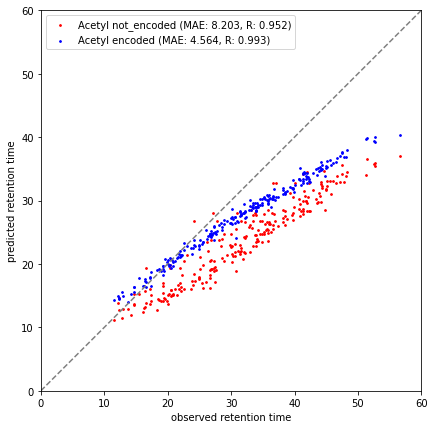

default data, without normalization
Pearson Correlation: 
 [[1.         0.97462201]
 [0.97462201 1.        ]]
RSE= 0.39743619135051184
R-Square= 0.9498880718159616
rmse= 0.3958867266155978
mae= 4.933344421683582


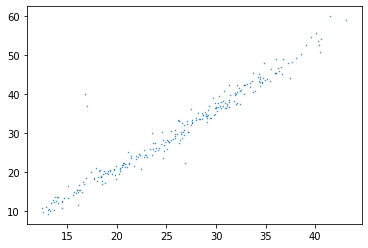

In [4]:
import wandb
from torch import nn
import torch.cuda
import numpy as np
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

# Loading the data
train_x = np.load('./data_matrix/ptms/train_x.npy')
train_y = np.load('./data_matrix/ptms/train_y.npy')
val_x = np.load('./data_matrix/ptms/val_x.npy')
val_y = np.load('./data_matrix/ptms/val_y.npy')
test_x = np.load('./data_matrix/ptms/test_x.npy')
test_y = np.load('./data_matrix/ptms/test_y.npy')
test_no_mod_x = np.load('./data_matrix/ptms/test_no_mod_x.npy')
test_no_mod_y = np.load('./data_matrix/ptms/test_no_mod_y.npy')

want_figure = True
over_test_set = False
training = True
save_model = True
path = './saved_models/14ptms/400_acetyl.pth'


# Initialize the hyper parameters

def get_config(lr=0.0003, epoch=400, batch=64, cnn_layers=5, fc_layers=1, drop=0.15, kernel=5, fc_output=1024):
    config = {
        "learning_rate": lr,
        "epochs": epoch,
        "batch_size": batch,
        "cnn_layers": cnn_layers,
        "fc_layers": fc_layers,
        "dropout": drop,
        "kernel_size": kernel,
        "fc_out": fc_output
    }

    return config


# Making the pytorch dataset

class MyDataset(Dataset):
    def __init__(self, sequences, retention):
        self.sequences = sequences
        self.retention = retention

    def __len__(self):
        return len(self.retention)

    def __getitem__(self, idx):
        return (self.sequences[idx], self.retention[idx])


# Initiate Dataloaders

train_dataset = MyDataset(train_x, train_y)
val_dataset = MyDataset(val_x, val_y)
test_dataset = MyDataset(test_x, test_y)
test_no_mod_dataset = MyDataset(test_no_mod_x, test_no_mod_y)

config = get_config()
dataloader_train = DataLoader(train_dataset, shuffle=True, batch_size=config["batch_size"])
dataloader_val = DataLoader(val_dataset, pin_memory=True)
dataloader_test = DataLoader(test_dataset, pin_memory=True)
dataloader_test_no_mod = DataLoader(test_no_mod_dataset, pin_memory=True)

import wandb

# wandb.init(config=config, project="Retention Prediction", entity="alirezak2", )
wandb.init(config=config, project="Hyper Parameters", entity="alirezak2", )


# Create Network architecture

class MyNet_firstOne(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.l = nn.ModuleList()

        self.l.append(nn.Conv1d(in_channels=9, out_channels=100, kernel_size=(3,), stride=(1,), padding=(1,)))
        self.l.append(nn.ReLU())
        self.l.append(nn.Dropout(p=0.2, inplace=False))

        self.l.append(nn.Conv1d(in_channels=100, out_channels=100, kernel_size=(3,), stride=(1,), padding=(1,)))
        self.l.append(nn.ReLU())
        self.l.append(nn.Dropout(p=0.2, inplace=False))

        self.l.append(nn.Conv1d(in_channels=100, out_channels=100, kernel_size=(3,), stride=(1,), padding=(1,)))
        self.l.append(nn.ReLU())
        self.l.append(nn.Dropout(p=0.2, inplace=False))

        self.l.append(nn.Conv1d(in_channels=100, out_channels=100, kernel_size=(3,), stride=(1,), padding=(1,)))
        self.l.append(nn.ReLU())
        self.l.append(nn.Dropout(p=0.2, inplace=False))

        self.l.append(nn.Conv1d(in_channels=100, out_channels=100, kernel_size=(3,), stride=(1,), padding=(1,)))
        self.l.append(nn.ReLU())
        self.l.append(nn.Dropout(p=0.2, inplace=False))

        self.l.append(nn.Conv1d(in_channels=100, out_channels=100, kernel_size=(3,), stride=(1,), padding=(1,)))
        self.l.append(nn.ReLU())
        self.l.append(nn.Dropout(p=0.2, inplace=False))

        self.l.append(nn.Conv1d(in_channels=100, out_channels=32, kernel_size=(4,), stride=(1,), padding=(1,)))
        self.l.append(nn.ReLU())

        self.l.append(nn.Flatten())

        self.l.append(nn.Linear(in_features=32 * 51, out_features=128))
        self.l.append(nn.ReLU())

        self.l.append(nn.Linear(in_features=128, out_features=1))
        self.l.append(nn.Linear(1, 1))

    def forward(self, x):
        for layer in self.l:
            x = layer(x)

        return x


class MyNet2(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.l = nn.ModuleList()

        self.l.append(nn.Conv1d(in_channels=30, out_channels=100, kernel_size=(3,), stride=(1,), padding=(1,)))
        self.l.append(nn.ReLU())

        self.l.append(nn.Conv1d(in_channels=100, out_channels=100, kernel_size=(3,), stride=(1,), padding=(1,)))
        self.l.append(nn.ReLU())

        self.l.append(nn.Conv1d(in_channels=100, out_channels=100, kernel_size=(3,), stride=(1,), padding=(1,)))
        self.l.append(nn.ReLU())

        self.l.append(nn.Conv1d(in_channels=100, out_channels=100, kernel_size=(3,), stride=(1,), padding=(1,)))
        self.l.append(nn.ReLU())

        self.l.append(nn.Conv1d(in_channels=100, out_channels=100, kernel_size=(3,), stride=(1,), padding=(1,)))
        self.l.append(nn.ReLU())

        self.l.append(nn.Conv1d(in_channels=100, out_channels=100, kernel_size=(3,), stride=(1,), padding=(1,)))
        self.l.append(nn.ReLU())

        self.l.append(nn.Conv1d(in_channels=100, out_channels=32, kernel_size=(4,), stride=(1,), padding=(1,)))
        self.l.append(nn.ReLU())

        self.l.append(nn.Flatten())

        self.l.append(nn.Linear(in_features=32 * 51, out_features=128))
        self.l.append(nn.ReLU())

        self.l.append(nn.Linear(in_features=128, out_features=1))

    def forward(self, x):
        for layer in self.l:
            x = layer(x)

        return x


padding = int((wandb.config['kernel_size'] - 1) / 2)


class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.l = nn.ModuleList()

        self.l.append(
            nn.Conv1d(in_channels=30, out_channels=100, kernel_size=(wandb.config['kernel_size'],), stride=(1,),
                      padding=(padding,)))
        self.l.append(nn.ReLU())

        for layer in range(wandb.config['cnn_layers']):
            self.l.append(
                nn.Conv1d(in_channels=100, out_channels=100, kernel_size=(wandb.config['kernel_size'],), stride=(1,),
                          padding=(padding,)))
            self.l.append(nn.ReLU())
            self.l.append(nn.Dropout(p=wandb.config['dropout'], inplace=False))

            self.l.append(
                nn.Conv1d(in_channels=100, out_channels=100, kernel_size=(wandb.config['kernel_size'],), stride=(1,),
                          padding=(padding,)))
            self.l.append(nn.ReLU())
            self.l.append(nn.Dropout(p=wandb.config['dropout'], inplace=False))

            self.l.append(nn.MaxPool1d(kernel_size=(wandb.config['kernel_size'],), stride=(1,), padding=(padding,)))

        self.l.append(
            nn.Conv1d(in_channels=100, out_channels=32, kernel_size=(wandb.config['kernel_size'],), stride=(1,),
                      padding=(padding,)))
        self.l.append(nn.ReLU())
        self.l.append(nn.Dropout(p=wandb.config['dropout'], inplace=False))
        self.l.append(nn.MaxPool1d(kernel_size=(wandb.config['kernel_size'],), stride=(1,), padding=(padding,)))

        self.l.append(nn.Flatten())

        self.l.append(nn.Linear(in_features=32 * train_x.shape[2], out_features=wandb.config['fc_out']))
        self.l.append(nn.ReLU())

        for layer in range(wandb.config['fc_layers']):
            self.l.append(nn.Linear(in_features=wandb.config['fc_out'], out_features=wandb.config['fc_out']))
            self.l.append(nn.ReLU())

        self.l.append(nn.Linear(in_features=wandb.config['fc_out'], out_features=int(wandb.config['fc_out'] / 2)))
        self.l.append(
            nn.Linear(in_features=int(wandb.config['fc_out'] / 2), out_features=int(wandb.config['fc_out'] / 4)))
        self.l.append(nn.Linear(in_features=int(wandb.config['fc_out'] / 4), out_features=1))

    def forward(self, x):
        for layer in self.l:
            x = layer(x)

        return x


# First look at Network

print(MyNet().parameters)
total_param = sum(p.numel() for p in MyNet().parameters())
print("Total Parameters =  ", total_param)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MyNet()
model.to(device)

for batch in dataloader_train:
    X, y = batch[0].to(device), batch[1].to(device)
    X = X.float()
    print(X.dtype)
    print('X is cuda:', X.is_cuda)
    print('X.shape:', X.shape)
    print('y.shape:', y.shape)
    outputs = model(X)
    print('outputs.shape:', outputs.shape)
    break


def train(model, loader, loss):
    current_loss = 0
    model.train()

    # reading the data
    for idx, batch in enumerate(loader):
        X, y = batch
        # move data to gpu if possible
        if device.type == 'cuda':
            X, y = X.to(device), y.to(device)
        # training steps
        optimizer.zero_grad()
        X = X.float()
        y = y.float()
        output = model(X)
        loss_fn = loss(output, y.reshape(-1, 1))
        loss_fn.backward()
        optimizer.step()

        current_loss += loss_fn.item() * X.size(0)
        correlation = np.corrcoef(output.cpu().detach().numpy().flat, y.cpu()).min()

        if idx % 100 == 0:  # print every 2000 mini-batches
            print('epoch: %d, train_loss: %.3f' % (epoch, loss_fn.item()), "Training correlation:", correlation)

            # showing some examples of prediction
            # print("5 Random samples: ")
            # for i in random.sample(range(0,len(output)),5):
            #    print('predict: %.3f, real: %.3f'%(output[i].item(),y[i].item()))
            # print('')

    epoch_loss = current_loss / len(loader.dataset)
    return epoch_loss


def validation(model, loader, loss):
    current_loss = 0
    model.eval()
    outputs = []
    ys = []
    # reading the data
    for idx, batch in enumerate(loader):
        X, y = batch
        # move data to gpu if possible
        if device.type == 'cuda':
            X, y = X.to(device), y.to(device)
        # validating steps

        X = X.float()
        y = y.float()
        output = model(X)
        ys.append(y.item())
        outputs.append(output.item())
        loss_fn = loss(output, y.reshape(-1, 1))

        current_loss += loss_fn.item() * X.size(0)
        # print('loss: %.3f' %(loss_fn.item()))
    # print('number of outputs: ',len(output))

    correlation = np.corrcoef(outputs, ys).min()
    epoch_loss = current_loss / len(loader.dataset)
    return epoch_loss, correlation, outputs, ys


model = MyNet()

model.to(device)

# Hyper parameters

epochs = wandb.config["epochs"]
learning_rate = wandb.config["learning_rate"]
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), learning_rate)
wandb.config["Total_Parameters"] = total_param
wandb.watch(model)

# Training the model
if training:
    for epoch in range(1, epochs + 1):
        loss_train = train(model, dataloader_train, loss_function)
        loss_valid, corr, output, y = validation(model, dataloader_val, loss_function)

        loss_test, corr_test, output_test, y_test = validation(model, dataloader_test, loss_function)
        loss_test_no_mod, corr_test_no_mod, output_test_no_mod, y_test_no_mod = validation(model, dataloader_test_no_mod,
                                                                                          loss_function)
        print('\n Epoch: {}  Train Loss: {:.4f}  Validation Loss: {:.4f}  Validation Correlation: {:.4f}\n'
              .format(epoch, loss_train, loss_valid, corr))
        if epoch == 2:
            if not corr > 0.3 or corr == "NaN":
                break
        wandb.log({
            "Epoch": epoch,
            "Train Loss Averaged": loss_train,
            "Correlation": corr,
            "Valid Loss Averaged": loss_valid,
            "Test set Correlation": corr_test,
            "No mod Test set Correlation": corr_test_no_mod,
            "Total Parameters": total_param
            # "Valid Acc": acc_valid
        })

if not training:
    model.load_state_dict(torch.load(path))

if save_model:
    torch.save(model.state_dict(), path)

if over_test_set:
    loss_test, corr_test, output_test, y_test = validation(model, dataloader_test, loss_function)
    print('\n Test set Loss: {:.4f}  Test set Correlation: {:.4f}\n'
          .format(loss_test, corr_test))
    print('\n Test set no mod Loss: {:.4f}  Test set no mod Correlation: {:.4f}\n'
          .format(loss_test_no_mod, corr_test_no_mod))
    output = output_test
    y = y_test

if want_figure:
    fig = plt.figure(figsize=(7, 7))
    ax1 = fig.add_subplot(111)
    mae_test = mean_absolute_error(output_test,y_test)
    mae_no_mod = mean_absolute_error(output_test_no_mod,y_test_no_mod)

    mod = 'Acetyl'

    ax1.scatter(y_test_no_mod,output_test_no_mod,c='r',label=mod+
                ' not_encoded (MAE: {:.3f}, R: {:.3f})'.format(mae_no_mod, corr_test_no_mod),s=3)
    ax1.scatter(y_test,output_test,c='b',label=mod+
                ' encoded (MAE: {:.3f}, R: {:.3f})'.format(mae_test, corr_test),s=3)

    plt.legend(loc='upper left')
    plt.xlabel('observed retention time')
    plt.ylabel('predicted retention time')
    plt.axis('scaled')
    ax1.plot([0, 60], [0, 60], ls="--", c=".5")
    plt.xlim(0,60)
    plt.ylim(0,60)
    plt.show()

# Metrics
output_arrayed = np.array(output).reshape(-1, 1)
y_arrayed = np.array(y).reshape(-1, 1)
linear_regressor = LinearRegression()
linear_regressor.fit(output_arrayed, y_arrayed)

num_data = len(y)

pear = np.corrcoef(output, y)
mse = mean_squared_error(output, y)
rmse = math.sqrt(mse / num_data)
rse = math.sqrt(mse / (num_data - 2))
rsquare = linear_regressor.score(output_arrayed, y_arrayed)
mae = mean_absolute_error(output, y)

print('default data, without normalization')
print('Pearson Correlation: \n', pear)
print('RSE=', rse)
print('R-Square=', rsquare)
print('rmse=', rmse)
print('mae=', mae)
plt.scatter(output, y, s=0.2, )


In [4]:
d13= np.load('data_matrix/14ptm/diamino13_custom_phospho9_normaltr/Acetyl/test_x.npy')
d5=np.load('data_matrix/14ptm/diamino_custom_phospho9_normaltr/Acetyl/test_x.npy')
pd.DataFrame(d5[0])

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,0.000000,1.220703,1.061523,0.765137,0.467773,1.061523,0.294434,0.765137,1.061523,0.294434,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,-0.323730,-0.968262,-0.586914,-1.414062,-0.685547,-1.493164,-0.586914,-0.968262,-1.493164,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,-0.584473,-0.995605,-0.450684,-1.325195,-0.914062,-1.573242,-0.450684,-0.995605,-1.573242,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,-0.734863,-0.733398,-0.759766,-0.733398,-0.734863,-0.734863,-0.759766,-0.733398,-0.734863,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,1.360352,-0.472412,0.060364,-0.899902,0.931152,0.231079,0.060364,-0.472412,0.231079,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,2.281250,0.000000,1.232422,0.000000,1.355469,0.000000,1.826172,0.000000,1.059570,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,-1.291992,0.000000,-2.000000,0.000000,-2.179688,0.000000,-1.554688,0.000000,-2.013672,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,-1.580078,0.000000,-1.775391,0.000000,-2.488281,0.000000,-1.446289,0.000000,-1.996094,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,-1.468750,0.000000,-1.493164,0.000000,-1.469727,0.000000,-1.493164,0.000000,-1.469727,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.887695,0.000000,-0.839355,0.000000,1.162109,0.000000,-0.412109,0.000000,-0.368164,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [5]:
pd.DataFrame(d13[0])

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,0.000000,1.220703,1.061523,0.765137,0.467773,1.061523,0.294434,0.765137,1.061523,0.294434,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,-0.323730,-0.968262,-0.586914,-1.414062,-0.685547,-1.493164,-0.586914,-0.968262,-1.493164,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,-0.584473,-0.995605,-0.450684,-1.325195,-0.914062,-1.573242,-0.450684,-0.995605,-1.573242,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,-0.734863,-0.733398,-0.759766,-0.733398,-0.734863,-0.734863,-0.759766,-0.733398,-0.734863,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,1.360352,-0.472412,0.060364,-0.899902,0.931152,0.231079,0.060364,-0.472412,0.231079,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,-0.862793,-0.070251,0.598145,-0.070251,-0.862793,-0.862793,0.598145,-0.070251,-0.862793,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,-0.569824,-0.569824,-0.569824,-0.569824,-0.569824,-0.569824,-0.569824,-0.569824,-0.569824,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,-1.627930,-0.468506,-0.482422,-0.416504,-1.627930,-1.627930,-0.482422,-0.468506,-1.627930,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,-0.629395,0.275879,1.125977,0.275879,-0.629395,-0.629395,1.125977,0.275879,-0.629395,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,-0.134888,-0.134888,-0.134888,-0.134888,-0.134888,-0.134888,-0.134888,-0.134888,-0.134888,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
